## AutoEncoder 修正
主要尝试修正onnx不支持pytorch中余弦相似度（operator cosine_similarity）计算

https://pytorch.org/docs/stable/nn.functional.html

1、修改为mse_loss:效果较差，难以拟合

2、实现余弦相似度计算

https://blog.csdn.net/qq_41487299/article/details/106299882
```
normalized_tensor_1=fv/fv.norm(dim=-1,keepdim=True)
normalized_tensor_2=fv_rec/fv_rec.norm(dim=-1,keepdim=True)
cos_simi = (normalized_tensor_1*normalized_tensor_2).sum(dim=-1)
```

In [86]:
import random
import cv2
from tqdm import tqdm

import io
import numpy as np
from matplotlib import pyplot as plt
import os
from PIL import Image
from glob import glob

from torch import nn, optim
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset
import torch.onnx

import torch.nn as nn
import torch.nn.init as init
from torch.nn import functional as F
import math
from torch.nn.parameter import Parameter

import torchvision
from torchvision import models

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch import Tensor
from typing import Optional


In [87]:
import torch
torch.cuda.set_device(0)
device = "cuda:0"

In [88]:
class ImageFolderDataset(object):

    def __init__(self, dataset_path, transform=None, ext=".png", eval=False):

        files = glob(os.path.join(dataset_path, "*" + ext))
        labels = []
        if len(files) == 0 and len(os.listdir(dataset_path)) != 0:
            for sub_dir in os.listdir(dataset_path):
                if eval:
                    _files = glob(os.path.join(dataset_path, sub_dir, "*" + ext))
                    if sub_dir != "good":
                        labels += [1] * len(_files)
                    else:
                        labels += [0] * len(_files)
                    files += _files
                else:
                    if sub_dir != "good":
                        files += glob(os.path.join(dataset_path, sub_dir, "*" + ext))

        self.files = files
        self.transform = transform
        self.eval = eval
        self.labels = labels

    def __getitem__(self, idx):
        img = cv2.imread(self.files[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ori_img = Image.fromarray(img) 

        if self.transform is not None:
            ori_img = self.transform(ori_img)

        if self.eval:
            return ori_img, self.labels[idx]
        else:
            return ori_img

    def __len__(self):
        return len(self.files)

In [89]:
train_dataset_path = './data/bottle_data/bottle/train/good/'
eval_dataset_path = './data/bottle_data/bottle/test/'

In [90]:
train_transform = transforms.Compose(
   [
        transforms.Resize((384, 384)),
        transforms.ToTensor()
    ]
)
eval_transform = transforms.Compose(
    [
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
    ]
)

In [91]:
train_dataset = ImageFolderDataset(train_dataset_path, transform=train_transform)
eval_dataset = ImageFolderDataset(eval_dataset_path, transform=eval_transform)

In [92]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=4)
eval_dataloader = DataLoader(eval_dataset, batch_size = 32, shuffle=True, num_workers=4)

In [93]:
class FeatureExtractor(nn.Module):

    def __init__(self, path=None):
        super().__init__()
        self.fv_group_info = [8, 9]
        print("init and load densenet161")
        model = torchvision.models.densenet161(pretrained=True)
        model = torch.nn.Sequential(*list(model.children()))[0]
        model.eval()

        net_s = []
        s = 0
        for end_i in self.fv_group_info:
            net_s.append(model[s:end_i])
            s = end_i
        self.net_s = nn.ModuleList(net_s)

    def forward(self, x, mean: Optional[Tensor] = None, std: Optional[Tensor] = None):
        out = []

        with torch.no_grad():
            for n in self.net_s:
                x = n(x)
                out.append(x)

        res = torch.cat(out, dim=1)

        if mean is not None:
            mean = mean.reshape(1, res.shape[1], res.shape[2], res.shape[3])
            res = res - mean
        if std is not None:
            std = std.reshape(1, res.shape[1], res.shape[2], res.shape[3])
            res = res / std

        res = torch.tanh(res)

        return res

In [94]:
class MemoryUnit(nn.Module):
    def __init__(self, mem_dim, fea_dim, shrink_thres=0.0025):
        super(MemoryUnit, self).__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim
        self.weight = Parameter(torch.Tensor(self.mem_dim, self.fea_dim))  # M x C
        self.bias = None
        self.shrink_thres = shrink_thres
        # self.hard_sparse_shrink_opt = nn.Hardshrink(lambd=shrink_thres)

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        att_weight = F.linear(input, self.weight)  # Fea x Mem^T, (TxC) x (CxM) = TxM
        att_weight = F.softmax(att_weight, dim=1)  # TxM
        # ReLU based shrinkage, hard shrinkage for positive value
        if (self.shrink_thres > 0):
            att_weight = hard_shrink_relu(att_weight, lambd=self.shrink_thres)
            # att_weight = F.softshrink(att_weight, lambd=self.shrink_thres)
            # normalize???
            att_weight = F.normalize(att_weight, p=1, dim=1)
            # att_weight = F.softmax(att_weight, dim=1)
            # att_weight = self.hard_sparse_shrink_opt(att_weight)
        mem_trans = self.weight.permute(1, 0)  # Mem^T, MxC
        output = F.linear(att_weight, mem_trans)  # AttWeight x Mem^T^T = AW x Mem, (TxM) x (MxC) = TxC
        return {'output': output, 'att': att_weight}  # output, att_weight

    def extra_repr(self):
        return 'mem_dim={}, fea_dim={}'.format(
            self.mem_dim, self.fea_dim is not None
        )


def _split(t, n_head, d_head):
    return t.view(t.size(0), n_head, d_head)


class MulHeadMemoryUnit(nn.Module):
    def __init__(self, mem_dim, fea_dim, n_head, d_head, dropout_attn=0.2, shrink_thres=0.0025):
        super(MulHeadMemoryUnit, self).__init__()
        self.mem_dim = mem_dim #128
        self.fea_dim = fea_dim #312
        self.n_head = n_head # 8
        self.d_head = d_head # 36
        self.scale = 1. / (d_head ** 0.5)
        self.bias = None
        self.layer_norm = nn.LayerNorm(fea_dim)

        self.q_net = nn.Linear(fea_dim, self.n_head * self.d_head, bias=False) # 312 -> 288
        self.o_net = nn.Linear(self.n_head * self.d_head, self.fea_dim, bias=False) # 288-> 312
        self.dropout_attn = nn.Dropout(dropout_attn)
        self.weight = Parameter(torch.Tensor(self.mem_dim, self.n_head, self.d_head))  # M x nh x dh

        self.shrink_thres = shrink_thres # 0.002
        # self.hard_sparse_shrink_opt = nn.Hardshrink(lambd=shrink_thres)

        self.reset_parameters()

    def reset_parameters(self):
        # stdv = 1. / math.sqrt(self.weight.size(1))
        # self.weight.data.uniform_(-stdv, stdv)
        # if self.bias is not None:
        #     self.bias.data.uniform_(-stdv, stdv)
        nn.init.orthogonal_(self.weight)

    def forward(self, q):

        q = self.layer_norm(q)
        head_v = self.weight
        head_q = self.q_net(q)
        head_q = _split(head_q, self.n_head, self.d_head)  # (b, nh, dh)

        # attn_score = torch.einsum('ind, jnd->ijn', head_q, head_v)
        attn_score = torch.bmm(head_q.permute(1, 0, 2), head_v.permute(1, 2, 0)).permute(1, 2, 0)
        attn_score = attn_score * self.scale
        att_weight = F.softmax(attn_score, dim=1)

        att_weight = self.dropout_attn(att_weight)

        # ReLU based shrinkage, hard shrinkage for positive value
        if (self.shrink_thres > 0):
            att_weight = hard_shrink_relu(att_weight, lambd=self.shrink_thres)
            # att_weight = F.normalize(att_weight, p=1, dim=1)
            att_weight = att_weight / torch.abs(att_weight).sum(dim=1, keepdim=True)
        # output = torch.einsum('ijn, jnd->ind', attn_score, head_v)
        output = torch.bmm(attn_score.permute(2, 0, 1), head_v.permute(1, 0, 2)).permute(1, 0, 2)
        b, n, d = output.shape
        output = self.o_net(output.reshape(b, n * d))

        return {'output': output, 'att': att_weight}  # output, att_weight

    def extra_repr(self):
        return 'mem_dim={}, fea_dim={}'.format(
            self.mem_dim, self.fea_dim is not None
        )


# NxCxHxW -> (NxHxW)xC -> addressing Mem, (NxHxW)xC -> NxCxHxW
class MemModule(nn.Module):
    def __init__(self, mem_dim, fea_dim, n_head, d_head, shrink_thres=0.0025):
        super(MemModule, self).__init__()
        self.mem_dim = mem_dim # 128
        self.fea_dim = fea_dim # 312
        self.shrink_thres = shrink_thres #0.002
        # self.memory = MemoryUnit(self.mem_dim, self.fea_dim, self.shrink_thres)
        self.memory = MulHeadMemoryUnit(self.mem_dim, self.fea_dim, n_head, d_head, self.shrink_thres)

    def forward(self, input):
        s = input.shape # torch.Size([2304, 312]
        l = len(s)

        if l == 2:
            x = input
        elif l == 3:
            x = input.permute(0, 2, 1)
        elif l == 4:
            x = input.permute(0, 2, 3, 1)
        elif l == 5:
            x = input.permute(0, 2, 3, 4, 1)
        else:
            x = []
            print('wrong feature map size')
        x = x.reshape(-1, s[1]) # torch.Size([2304, 312]
        #
        y_and = self.memory(x)  #dict
        #
        y = y_and['output'] # torch.Size([2304, 312])
        att = y_and['att'] # torch.Size([2304, 128, 8])

        if l == 2:
            pass
        elif l == 3:
            y = y.view(s[0], s[2], s[1])
            y = y.permute(0, 2, 1)
            att = att.view(s[0], s[2], self.mem_dim)
            att = att.permute(0, 2, 1)
        elif l == 4:
            y = y.view(s[0], s[2], s[3], s[1])
            y = y.permute(0, 3, 1, 2)
            att = att.view(s[0], s[2], s[3], self.mem_dim)
            att = att.permute(0, 3, 1, 2)
        elif l == 5:
            y = y.view(s[0], s[2], s[3], s[4], s[1])
            y = y.permute(0, 4, 1, 2, 3)
            att = att.view(s[0], s[2], s[3], s[4], self.mem_dim)
            att = att.permute(0, 4, 1, 2, 3)
        else:
            y = x
            att = att
            print('wrong feature map size')
        return y, att


# relu based hard shrinkage function, only works for positive values
def hard_shrink_relu(input, lambd=0, epsilon=1e-12):
    output = (F.relu(input - lambd) * input) / (torch.abs(input - lambd) + epsilon)
    return output


这个AutoEncoder结构中，MemModule（Memory Module）的作用是引入一个具有多头注意力机制的内存模块，以增强模型对输入数据的建模能力。具体来说，MemModule 接收来自编码器（self.enc）的输出，并将其输入多头注意力机制中进行处理。

以下是 MemModule 在 AutoEncoder 结构中的作用：

    输入变换：
    forward 方法中的第一部分负责对输入进行一些形状的变换，以适应多头注意力模块的输入要求。根据输入张量的维度，它进行了不同的维度变换。

    多头注意力机制处理：
    forward 方法中的第二部分调用了内存模块中的 MulHeadMemoryUnit（多头注意力单元）进行处理。这个单元通过多头注意力机制处理输入，并输出处理后的特征和注意力权重。

    输出变换：
    forward 方法的最后部分对多头注意力机制的输出进行逆变换，以恢复与编码器输出相同的形状。

    返回结果：
    forward 方法最终返回处理后的特征和注意力权重。
    
    总体来说，MemModule 的作用是通过多头注意力机制对编码器的输出进行更加灵活和富有表征能力的处理，以提高模型对输入数据的建模效果。这种机制允许模型在学习表示时更加关注输入中不同部分的信息，从而提高整体的特征学习能力。


In [95]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.enc = torch.nn.Sequential(
            nn.Linear(in_features=2496, out_features=1248),
            nn.BatchNorm1d(1248),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1248, out_features=624),
            nn.BatchNorm1d(624),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=624, out_features=312),
            nn.BatchNorm1d(312),
            nn.ReLU())

        self.dec = torch.nn.Sequential(
            nn.Linear(in_features=312, out_features=624),
            nn.BatchNorm1d(624),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=624, out_features=1248),
            nn.BatchNorm1d(1248),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=1248, out_features=2496),
            nn.Tanh()
        )
        # 定义内存模块
        self.mem_rep = MemModule(mem_dim=128,
                                 fea_dim=312,
                                 n_head=8,
                                 d_head=36,
                                 shrink_thres=0.002)

    def forward(self, x):
        nf = x.size(1)

        x = x.permute(0, 2, 3, 1)
        x = x.reshape(-1, nf)
        
        #print('x: ', x.shape) # torch.Size([2304, 2496])
        enc_out = self.enc(x) 
        #print('enc_out: ', enc_out.shape) # torch.Size([2304, 312])
        
        mem_out = self.mem_rep(enc_out)[0] # 将编码器的输出通过内存模块
        #print('mem_out: ', mem_out.shape) # torch.Size([2304, 312])
        
        dec_out = self.dec(mem_out)
        #print('dec_out: ', dec_out.shape) # torch.Size([2304, 2496])
        return dec_out

In [96]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(in_features=2496, out_features=156),
            nn.BatchNorm1d(156),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=156, out_features=78),
            nn.BatchNorm1d(78),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=78, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [97]:
class ValuePredictor(nn.Module):
    def __init__(self):
        super(ValuePredictor, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(in_features=2496, out_features=156),
            nn.BatchNorm1d(156),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=156, out_features=78),
            nn.BatchNorm1d(78),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=78, out_features=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [98]:
class MsAEDefectDetector(nn.Module):

    def __init__(self, mean=None, std=None, inference=True):
        super().__init__()

        self.mean = mean
        self.std = std
        self.extractor = FeatureExtractor()
        self.ae = AutoEncoder()
        self.vp = ValuePredictor()
        self.discriminator = Discriminator()
        self.l1_loss = nn.L1Loss()
        self.inference = inference

    def backward_G(self, img, lmbda=10):

        fv = self.extractor(img, self.mean, self.std) # fv 特征提取结果
        bsz, _, h, w = fv.shape

        fv_rec = self.ae(fv) # ae网络

        nf = fv.size(1)

        fv = fv.permute(0, 2, 3, 1)
        fv = fv.reshape(-1, nf)

        #ae_loss = (1 - F.cosine_similarity(fv, fv_rec)) # ae_loss: 1- 输入与重建后的相似性
        # ae_loss = F.mse_loss(fv, fv_rec)
        normalized_tensor_1=fv/fv.norm(dim=-1,keepdim=True)
        normalized_tensor_2=fv_rec/fv_rec.norm(dim=-1,keepdim=True)
        cos_simi = (normalized_tensor_1*normalized_tensor_2).sum(dim=-1)
        ae_loss = 1 - cos_simi
        
        rec_loss = ae_loss.mean()
        
        # loss_g减小，说明交叉熵变小，重建的趋近于0，是OK的。（0，ok ,1 ng)
        loss_g = F.binary_cross_entropy(self.discriminator(fv_rec),
                                        torch.ones(fv.shape[0], 1, device=fv.device, dtype=fv.dtype))

        return fv, fv_rec.detach(), loss_g + lmbda * rec_loss

    def backward_D(self, fv, fv_rec):
        loss_d = 0.5 * (F.binary_cross_entropy(self.discriminator(fv),
                                               torch.ones(fv.shape[0], 1, device=fv.device, dtype=fv.dtype)) +
                        F.binary_cross_entropy(self.discriminator(fv_rec),
                                               torch.zeros(fv.shape[0], 1, device=fv.device, dtype=fv.dtype)))
        return loss_d

    def backward_VP(self, fv, fv_rec):
        pre_err = self.vp(fv).squeeze(-1) #fv特征提取后再变换为（2304，2496） fv_rec为ae结果
        #ae_err = (1 - F.cosine_similarity(fv, fv_rec)) #相似度越高，ae_err越小。
        # ae_err = F.mse_loss(fv, fv_rec)
        normalized_tensor_1=fv/fv.norm(dim=-1,keepdim=True)
        normalized_tensor_2=fv_rec/fv_rec.norm(dim=-1,keepdim=True)
        cos_simi = (normalized_tensor_1*normalized_tensor_2).sum(dim=-1)
        ae_err = 1 - cos_simi

        return self.l1_loss(pre_err, ae_err) #pre_err [2304]; ae_err [2304]

    def forward(self, img):
        fv = self.extractor(img, self.mean, self.std)

        bsz, _, h, w = fv.shape

        fv_rec = self.ae(fv) # autoencoder

        nf = fv.size(1)

        fv = fv.permute(0, 2, 3, 1)
        fv = fv.reshape(-1, nf)
        pre_err = self.vp(fv) # 特征提取后的结果进入valuepredicter
        if self.inference:
            #ae_err = 1 - F.cosine_similarity(fv, fv_rec) # 比较特征提取后的结果与重建后的相似度，相似度越小，差异性（ae_err)越大
            # ae_err = F.mse_loss(fv, fv_rec)
            normalized_tensor_1=fv/fv.norm(dim=-1,keepdim=True)
            normalized_tensor_2=fv_rec/fv_rec.norm(dim=-1,keepdim=True)
            cos_simi = (normalized_tensor_1*normalized_tensor_2).sum(dim=-1)
            ae_err = 1 - cos_simi
            
            err = ((ae_err - pre_err.squeeze(-1)).exp()).reshape(bsz, h, w) #差异性再减去特征图
            # err = ae_err.exp().reshape(bsz, h, w)
            return err
        else:
            return fv, fv_rec, pre_err

In [99]:
def requires_grad(model, grad=False):
    for param in model.parameters():
        param.requires_grad = grad

In [100]:
epochs = 1000
lr = 1e-3
checkpoints_dir = "./models/10_triain_autoencoder_amend/bottle/"
os.makedirs(checkpoints_dir, exist_ok=True)
pretrained_weights = None #预训练权重

In [101]:
mu_path = './data/09_train_autoencoder/stat/bottle/fvs_mu.bin'
std_path = './data/09_train_autoencoder/stat/bottle/fvs_std.bin'

In [102]:
if mu_path is not None and std_path is not None:
    mu = torch.from_numpy(np.fromfile(mu_path, dtype=np.float32)).to(device)
    std = torch.from_numpy(np.fromfile(std_path, dtype=np.float32)).to(device)
else:
    mu = None
    std = None

In [103]:
mu.shape

torch.Size([1437696])

In [104]:
model = MsAEDefectDetector(mu, std).to(device)

init and load densenet161


/root/anaconda3/envs/wood_pytorch/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [105]:
print(pretrained_weights)

None


In [106]:
if pretrained_weights is not None:
    model.load_state_dict(torch.load(pretrained_weights, map_location=device))

In [107]:
# optim
dis_optim = optim.Adam(model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
ae_optim = optim.Adam(model.ae.parameters(), lr=lr, betas=(0.5, 0.999))
vp_optim = optim.Adam(model.vp.parameters(), lr=lr)

### 训练

In [108]:
for epoch in range(epochs):
    model.train()
    
    for i, img in enumerate(train_dataloader):
        img = img.to(device) # torch.Size([32, 3, 384, 384])
        
        # train autoencoder
        requires_grad(model.discriminator, False)
        requires_grad(model.vp, False)
        requires_grad(model.ae, True)
        
        fv, fv_rec, loss_ae = model.backward_G(img) # fv 特征提取后变换为（c， 2496） fv_rec为ae输出（c, 2496)
        
        ae_optim.zero_grad() #梯度归0
        loss_ae.backward() #反向传播
        ae_optim.step() # 参数更新
        
        # train discriminator
        requires_grad(model.discriminator, True)
        requires_grad(model.vp, False)
        requires_grad(model.ae, False)
        
        loss_dis = model.backward_D(fv, fv_rec)
        
        dis_optim.zero_grad()
        loss_dis.backward()
        dis_optim.step()
        
        # train ValuePredicter
        requires_grad(model.discriminator, False)
        requires_grad(model.ae, False)
        requires_grad(model.vp, True)
        
        loss_vp = model.backward_VP(fv, fv_rec)
        
        vp_optim.zero_grad()
        loss_vp.backward()
        vp_optim.step()
        
        print('[Epoch %d/%d] [Batch %d/%d] [d_loss: %f] [g_loss: %f] [vp_loss: %f]'% (epoch, epochs, i, len(train_dataloader), loss_dis.item(), loss_ae.item(), loss_vp.item()))
        
        
    if epoch > 990:
        torch.save(model, f"{checkpoints_dir}/10_autoencoder_%d.pth" % (epoch,))
    
    if eval_dataloader is not None:
        model.eval()
        
        for i, img in enumerate(eval_dataloader):
            img = img.to(device)
            
            with torch.no_grad():
                err = model(img)
                print('err shape: ', err.shape)
                err = err[0].cpu().numpy() # bs, h, w
                
                # 边界处理
                pad = 1
                err_mean = np.mean(err[pad:-pad, pad:-pad])
                err[:pad, :] = err_mean
                err[-pad:, :] = err_mean
                err[:, :pad] = err_mean
                err[:, -pad:] = err_mean
                
            err = cv2.GaussianBlur(err, (3, 3), 1)
            
            img = img[0].permute(1, 2, 0).cpu().numpy()
            err = cv2.resize(err, (img.shape[1], img.shape[0]))
            
            fig, axes = plt.subplots(ncols=3, figsize=(10, 10))
            
            for ax in axes.flat:
                # Remove all xticks and yticks...
                ax.set(xticks=[], yticks=[])
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
            
            print('err max: ', err.max())
            amap_threshold = np.mean(err[16:-16, 16:-16]) + 2.5 * np.std(err[16:-16, 16:-16])
            print('amap_threshold: ', amap_threshold)
            
            axes[0].imshow(img)
            axes[1].imshow(err, cmap="gray")
            axes[2].imshow(err > amap_threshold, cmap="gray")
            
            plt.gca().set_axis_off()

            plt.savefig(f"./data/10_triain_autoencoder_amend/output/bottle/{epoch}.jpg")
            plt.show()
            plt.close()
            break

### 推理

In [109]:
re_model = torch.load('./models/10_triain_autoencoder_amend/bottle/10_autoencoder_999.pth')

In [110]:
re_model.eval()

MsAEDefectDetector(
  (extractor): FeatureExtractor(
    (net_s): ModuleList(
      (0): Sequential(
        (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _D

torch.Size([32, 3, 384, 384])
torch.Size([32, 24, 24])
err:  (24, 24)
errshape:  (384, 384)
err max:  1.4031862
amap thrshold:  1.240443117916584
torch.Size([31, 3, 384, 384])
torch.Size([31, 24, 24])
err:  (24, 24)
errshape:  (384, 384)
err max:  1.1461624
amap thrshold:  1.1348681673407555


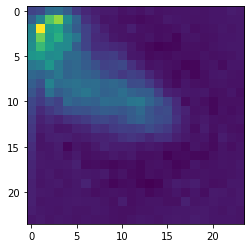

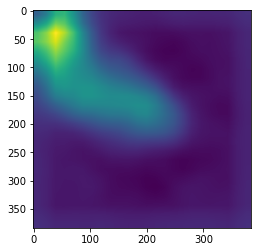

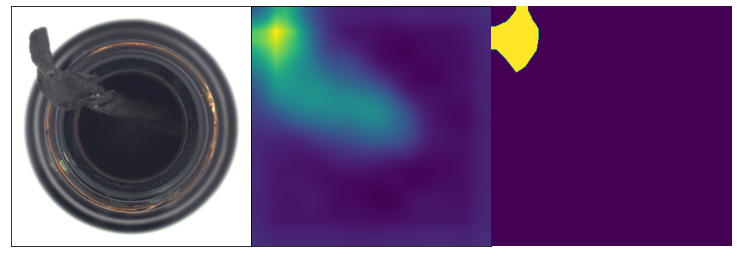

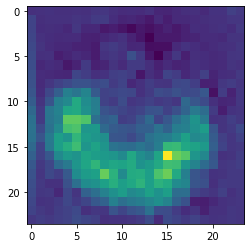

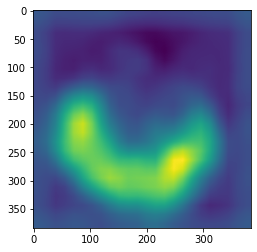

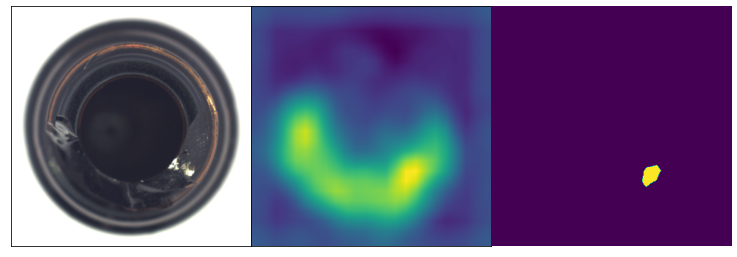

In [111]:
for i, img in enumerate(eval_dataloader):
    img = img.to(device)
    print(img.shape)
    
    with torch.no_grad():
        err = re_model(img)
        print(err.shape)
        err = err[0].cpu().numpy()
        print('err: ', err.shape)
        fix, ax = plt.subplots()
        ax.imshow(err)
        
        pad = 1

        err_mu = np.mean(err[pad:-pad, pad:-pad])
        err[:pad, :] = err_mu
        err[-pad:, :] = err_mu
        err[:, :pad] = err_mu
        err[:, -pad:] = err_mu
        err = cv2.GaussianBlur(err, (3, 3), 1)
        
        err = cv2.resize(err, (384, 384))
        fix, ax = plt.subplots()
        ax.imshow(err)
        
        # (c, h, w) -> ( h, w, c)
        img = img[0].permute(1, 2, 0).cpu().numpy()
        print('errshape: ', err.shape)
        
        fig, axes = plt.subplots(ncols=3, figsize=(10, 10))
        for ax in axes.flat:
            # Remove all xticks and yticks...
            ax.set(xticks=[], yticks=[])
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())

        print('err max: ',err.max())
        amap_threshold = np.mean(err[16:-16, 16:-16]) + 2.5 * np.std(err[16:-16, 16:-16])
        print('amap thrshold: ',amap_threshold)
        axes[0].imshow(img)
        axes[1].imshow(err, vmax=err.max())
        axes[2].imshow(err > amap_threshold)
        plt.gca().set_axis_off()

torch.Size([3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 24, 24])
(384, 384)
x_re maxn:  1.1461624
(384, 384)


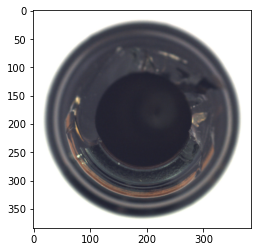

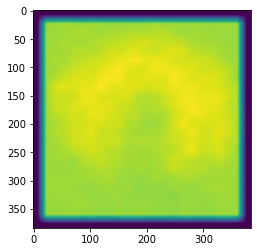

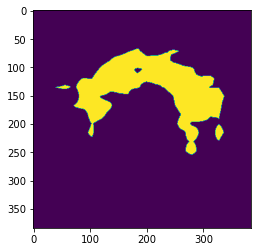

In [112]:
x = eval_dataset[2]
t = eval_dataset[2]
t = t.permute(1, 2, 0)
fix, ax = plt.subplots()
ax.imshow(t)
with torch.no_grad():
    print(x.shape)
    x = x.unsqueeze_(0)
    print(x.shape)
    
    x_re = re_model(x.to(device))
    
    # 特征图
    print(x_re.shape)
    x_re = x_re[0].cpu().numpy()

    pad = 1
    x_re[:pad, :] = 0
    x_re[-pad:, :] = 0
    x_re[:, :pad] = 0
    x_re[:, -pad:] = 0
    
    x_re = cv2.resize(x_re, (384, 384))
    print(x_re.shape)
    fix, ax = plt.subplots()
    ax.imshow(x_re)
    
    print('x_re maxn: ', err.max())
    
    # 残差图
    amap_threshold = 1.1
    x_re = (x_re > amap_threshold)
    print(x_re.shape)
    fix, ax = plt.subplots()
    ax.imshow(x_re)
    

## 模型转换

In [113]:
import torch.onnx
import onnx

In [115]:
input_image = torch.randn(1, 3, 384, 384)
torch.onnx.export(re_model, input_image.cuda(), 'models/10_triain_autoencoder_amend/bottle/10_train_autoencoder_999_model.onnx')

/root/anaconda3/envs/wood_pytorch/lib/python3.7/site-packages/torch/onnx/symbolic_opset9.py:631: UserWarning: ONNX export squeeze with negative axis -1 might cause the onnx model to be incorrect. Negative axis is not supported in ONNX. Axis is converted to 1 based on input shape at export time. Passing an tensor of different rank in execution will be incorrect.
  "Passing an tensor of different rank in execution will be incorrect.")
/root/anaconda3/envs/wood_pytorch/lib/python3.7/site-packages/torch/onnx/symbolic_opset9.py:653: UserWarning: This model contains a squeeze operation on dimension 1. If the model is intended to be used with dynamic input shapes, please use opset version 11 to export the model.
  "intended to be used with dynamic input shapes, please use opset version 11 to export the model.")


### onnxruntime推理

In [116]:
import onnx

onnx_model = onnx.load('./models/10_triain_autoencoder_amend/bottle/10_train_autoencoder_999_model.onnx')
onnx.checker.check_model(onnx_model)

In [117]:
import onnxruntime

In [118]:
x = eval_dataset[2]
print(x.shape)
x = x.unsqueeze_(0)
print('model input shape: ', x.shape)

torch.Size([3, 384, 384])
model input shape:  torch.Size([1, 3, 384, 384])


In [146]:
ort_session = onnxruntime.InferenceSession("models/10_triain_autoencoder_amend/bottle/10_train_autoencoder_999_model.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
print('type:', type(ort_inputs)) # dict
#print(ort_inputs)
temp = ort_inputs['input.1'] # numpy.ndarray
print(temp.shape) # (1, 1, 28, 28)

ort_outs = ort_session.run(None, ort_inputs)

print(type(ort_outs))
# print(ort_outs)

type: <class 'dict'>
{'input.1': array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]]], dtype=float32)}
(1, 3, 384, 384)
<class 'list'>


(1, 1, 24, 24)
(384, 384)
x_re maxn:  1.1461624
(384, 384)


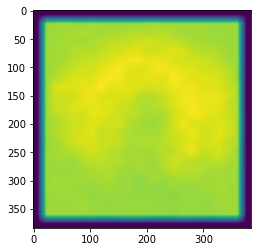

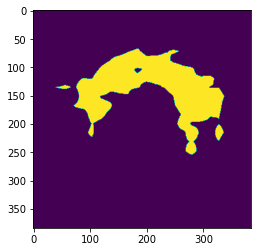

In [142]:
    # 特征图
    out = np.array(ort_outs)
    print(out.shape)
    x_re = out[0][0]

    pad = 1
    x_re[:pad, :] = 0
    x_re[-pad:, :] = 0
    x_re[:, :pad] = 0
    x_re[:, -pad:] = 0
    
    x_re = cv2.resize(x_re, (384, 384))
    print(x_re.shape)
    fix, ax = plt.subplots()
    ax.imshow(x_re)
    
    print('x_re maxn: ', err.max())
    
    # 残差图
    amap_threshold = 1.1
    # x_re = (x_re > amap_threshold)
    ret, im_fixed = cv2.threshold(x_re, amap_threshold, 255, cv2.THRESH_BINARY)
#     if x_re < amap_threshold:
#         x_re = 0
    print(im_fixed.shape)
    cv2.imwrite('./data/10_triain_autoencoder_amend/result.jpg', im_fixed)
    fix, ax = plt.subplots()
    ax.imshow(im_fixed)

In [143]:
print(im_fixed.max())

255.0


In [130]:
np.testing.assert_allclose(to_numpy(model(x.cuda())), ort_outs[0], rtol=1e-03, atol=1e-05)